Technical Analysis libraries:   
* pip install TA-Lib         ---- 150 + indicators, supports work with pandasd. TA-Lib is the golden standard, but it is not the easiest one to understand and dive deep into.
* pip install --upgrade ta   ---- 42 indicators, supports work with pandas. ( Can run all 42 indicators in one line of code).  
* pip install pandas_ta      ---- 130+ indicators, supports work with pandas.   

*** Read more here : https://medium.com/geekculture/top-4-python-libraries-for-technical-analysis-db4f1ea87e09

Portfolio Assessment libraries:
* pip install pyfolio -- Portfolio analysis (seems like it is not supported anymore)

In [1]:
import requests as r
import pandas as pd 
import numpy as np
import json as j
import time
from datetime import timedelta
from datetime import datetime 
from scipy.stats import geom

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import mplfinance as mpf
import seaborn as sns
import os
import shutil
from Scraping import Navigation as Nav
from Data_Retrieval_Transformation import AlphaVantageAPI as AV
from Data_Retrieval_Transformation import OtherData, Analysis
from Data_Retrieval_Transformation import Indicators as Ind


MARKETS = ['NASDAQ', 'NYSE']
LAST_DAY_DATA_DIR = r'D:\Study 2018 and later\Mignimind Bootcamp\Code\Stock Analysis\P1-Indicators-Chart-Analysis\Data\Last Day'
STOCK_LIST = ['MSFT','TSLA','BABA','VZ','AAPL', 'NEM'] # 


# API Settings
import yaml
def load_yaml_file(filename):
    with open(filename, "r") as file:
        data = yaml.safe_load(file)
    return data

KEY = load_yaml_file(r"C:\Users\Vasyl\Google Drive\Vantage API Secret key\AlphaVantageAPIPremiumKey.yaml")['ALPHA_VANTAGE_PREMIUM_KEY']
CALLS_PER_MINUTE = 75
SLEEP_TIME = 60/CALLS_PER_MINUTE + (60/CALLS_PER_MINUTE)*0.1 # 75 requests per minute with 10% buffer

## Part 1 - Data Collection, Basic Analysis and Visualization

### Getting data from aplha vantage API and storing it in csv files

Get Daily data:

In [2]:
# av.get_daily_adjusted_data_for_list(STOCK_LIST, r'..\P1-Indicators-Chart-Analysis\Data\Daily', KEY, 'compact', SLEEP_TIME)

Get Hourly data: (for the last 2 years)

In [3]:
# for ticker in STOCK_LIST:
#     av.get_intraday_extended_data(ticker,KEY,SLEEP_TIME,directory=r'..\P1-Indicators-Chart-Analysis\Data\Hourly', slice='2yearData')

### Data Visualization and Chart Analysis

In [4]:
# load data from csvs
aapl_d_source = pd.read_csv(r'..\P1-Indicators-Chart-Analysis\Data\Daily\AAPL-daily.csv', index_col=0,parse_dates=True)
baba_d_source = pd.read_csv(r'..\P1-Indicators-Chart-Analysis\Data\Daily\BABA-daily.csv', index_col=0,parse_dates=True)
msft_d_source = pd.read_csv(r'..\P1-Indicators-Chart-Analysis\Data\Daily\MSFT-daily.csv', index_col=0,parse_dates=True)
nem_d_source = pd.read_csv(r'..\P1-Indicators-Chart-Analysis\Data\Daily\NEM-daily.csv', index_col=0,parse_dates=True)
tsla_d_source = pd.read_csv(r'..\P1-Indicators-Chart-Analysis\Data\Daily\TSLA-daily.csv', index_col=0,parse_dates=True)
vz_d_source= pd.read_csv(r'..\P1-Indicators-Chart-Analysis\Data\Daily\VZ-daily.csv', index_col=0,parse_dates=True)

aapl_d_source.index.rename('Date', inplace=True)
baba_d_source.index.rename('Date', inplace=True)
msft_d_source.index.rename('Date', inplace=True)
nem_d_source.index.rename('Date', inplace=True)
tsla_d_source.index.rename('Date', inplace=True)
vz_d_source.index.rename('Date', inplace=True)

In [5]:
aapl_d_source.head(2)

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient
Date,,,,,,,,
2023-03-10,150.210,150.940,147.6096,148.50,148.50,68572400,0.0,1.0
2023-03-09,153.559,154.535,150.2250,150.59,150.59,53833582,0.0,1.0


Check if data is actually adjusted for splits and dividends as it should be per the API documentation:

In [6]:
aapl_d_source['8. split coefficient'].value_counts()

1.000000    5873
2.000000       2
4.000000       1
7.000007       1
Name: 8. split coefficient, dtype: int64

In [7]:
splits = aapl_d_source[~aapl_d_source['8. split coefficient'].isin([1])].copy(deep=True)
splits['8. split coefficient'] = splits['8. split coefficient'].astype('int')
splits

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient
Date,,,,,,,,
2020-08-31,127.58,131.00,126.00,129.04,126.935683,223505733,0.0,4
2014-06-09,92.70,93.88,91.75,93.70,20.831391,75414997,0.0,7
2005-02-28,44.68,45.14,43.96,44.86,1.361730,11635900,0.0,2
2000-06-21,50.50,56.94,50.31,55.63,0.844327,4375000,0.0,2


Quick check online confirms that these are the dates of the splits for AAPL stock.  
Let's see if the next day's open price is adjusted for the split.

In [8]:
aapl_d_source.loc['2000-06-19':'2000-06-26':-1]
# aapl_d_source.loc['2005-02-24':'2005-03-01':-1]
# aapl_d_source.loc['2014-06-06':'2014-06-11':-1]
# aapl_d_source.loc['2020-08-27':'2020-09-02':-1]

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient
Date,,,,,,,,
2000-06-19,90.56,97.87,89.81,96.62,0.733228,3517900,0.0,1.0
2000-06-20,98.50,103.94,98.37,101.25,0.768364,4476700,0.0,1.0
2000-06-21,50.50,56.94,50.31,55.63,0.844327,4375000,0.0,2.0
2000-06-22,55.75,57.63,53.56,53.75,0.815794,8352000,0.0,1.0
2000-06-23,53.78,54.63,50.81,51.69,0.784528,3660100,0.0,1.0
2000-06-26,52.50,54.75,52.13,54.13,0.821561,3309900,0.0,1.0


As we can see the column "5. adjusted close" indicates the adjusted close price for the split. Great.   
However to use some of the indicators we need to use the high, low, open and close prices.

Adjusting for the splits:

* Saving function to reuse later.

In [9]:
aapl_d, aapl_splits = AV.adjust_price_for_splits(aapl_d_source)
baba_d, baba_splits = AV.adjust_price_for_splits(baba_d_source)
msft_d, msft_splits = AV.adjust_price_for_splits(msft_d_source)
nem_d, nem_splits = AV.adjust_price_for_splits(nem_d_source)
tsla_d, tsla_splits = AV.adjust_price_for_splits(tsla_d_source)
vz_d, vz_splits = AV.adjust_price_for_splits(vz_d_source)

aapl_d.name = 'AAPL'
baba_d.name = 'BABA'
msft_d.name = 'MSFT'
nem_d.name = 'NEM'
tsla_d.name = 'TSLA'
vz_d.name = 'VZ'
# For Easy access to the data and manipulation
growth = [aapl_d, baba_d, msft_d, tsla_d]
value = [nem_d, vz_d]
all_stocks = [aapl_d, baba_d, msft_d, nem_d, tsla_d, vz_d]

In [10]:
# aapl_d.loc['2000-06-19':'2000-06-26':1]
# aapl_d.loc['2005-02-24':'2005-03-01':1]
aapl_d.loc['2014-06-06':'2014-06-11':1]
# aapl_d_.loc['2020-08-27':'2020-09-02':1]

,Open,High,Low,Close,5. adjusted close,Volume,7. dividend amount,8. split coefficient
Date,,,,,,,,
2014-06-06,23.210714,23.259286,23.016786,23.056071,20.503289,12497800,0.0,1.000000
2014-06-09,23.175000,23.470000,22.937500,23.425000,20.831391,75414997,0.0,7.000007
2014-06-10,23.682500,23.762500,23.392500,23.562500,20.953667,62777000,0.0,1.000000
2014-06-11,23.532500,23.690000,23.367500,23.465000,20.866962,45681000,0.0,1.000000


#### Plotting stock price and volume for the last 2 years

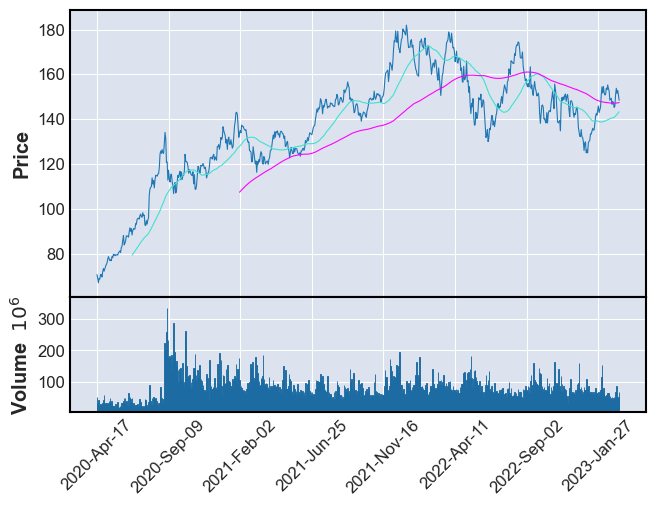

In [11]:
mpf.plot(aapl_d[-730::], type='line',  volume=True,  mav=(50, 200)) # quick plot

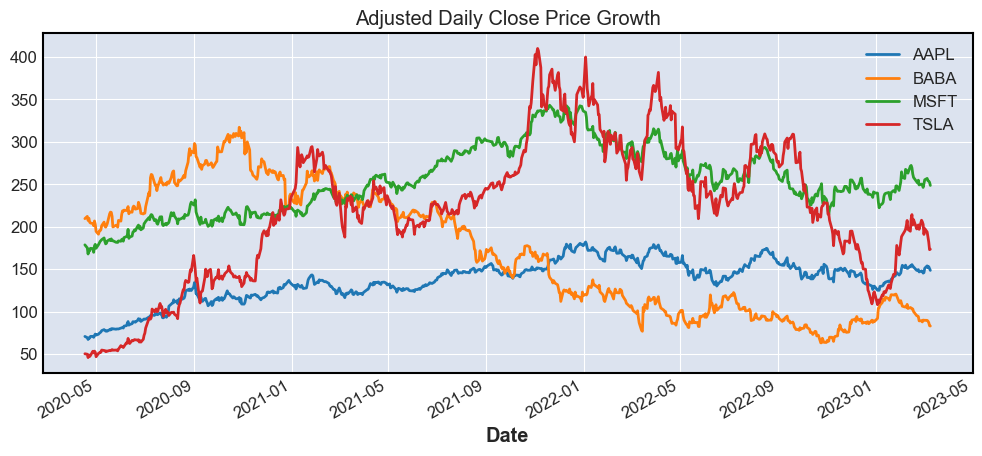

In [12]:
aapl_d['Close'][-730:].plot(figsize=(12,5),label='AAPL', title='Adjusted Daily Close Price Growth')
baba_d['Close'][-730:].plot(label='BABA')
msft_d['Close'][-730:].plot(label='MSFT')
tsla_d['Close'][-730:].plot(label='TSLA')
plt.legend()

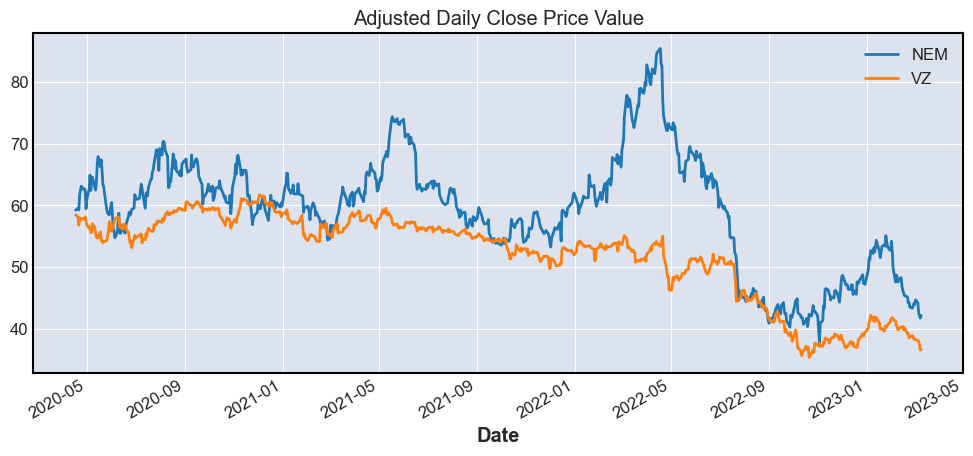

In [13]:
nem_d['Close'][-730:].plot(label='NEM',figsize=(12,5), title='Adjusted Daily Close Price Value')
vz_d['Close'][-730:].plot(label='VZ')
plt.legend()

In [14]:
for stock in all_stocks:
    stock['MA30'] = stock['Close'].rolling(30).mean()
    stock['MA120'] = stock['Close'].rolling(120).mean()

<Axes: title={'center': 'APPL MA30 and MA120'}, xlabel='Date'>

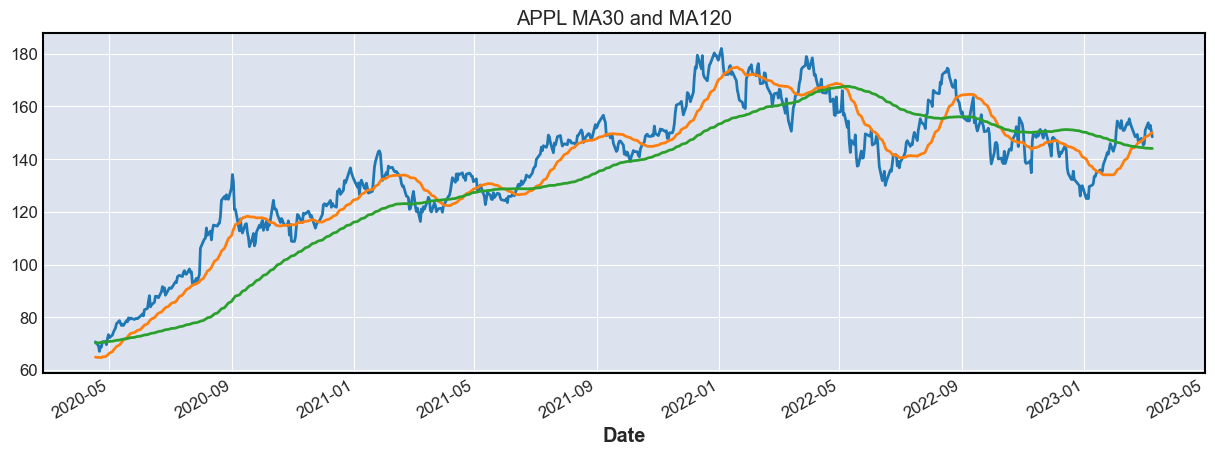

In [15]:
aapl_d['Close'][-730:].plot(figsize=(15,5),label='AAPL', title='APPL MA30 and MA120')
aapl_d['MA30'][-730:].plot(label='MA30')
aapl_d['MA120'][-730:].plot(label='MA120')

#### Conditional probability.
Determining probability of the stock moving up or down based on previous day movement (+2%, +3%, +4%, +5%, +6%) and (-2%, -3%,-4%, -5%, -6%) for different time frames


In [16]:
for stock in all_stocks:
    stock['Daily Return'] = stock['Close'].pct_change() # Calculate the daily returns for each stock into a new column called 'Daily Return'
    conditions = [stock['Daily Return'] < -0.05, 
                stock['Daily Return'].between(-0.05, -0.04, inclusive='left'), 
                stock['Daily Return'].between(-0.04, -0.03, inclusive='left'), 
                stock['Daily Return'].between(-0.03, -0.02, inclusive='left'), 
                stock['Daily Return'].between(-0.02, -0.01, inclusive='left'), 
                stock['Daily Return'].between(-0.01, 0, inclusive='left'), 
                stock['Daily Return'].between(0, 0.01, inclusive='left'), 
                stock['Daily Return'].between(0.01, 0.02, inclusive='left'), 
                stock['Daily Return'].between(0.02, 0.03, inclusive='left'), 
                stock['Daily Return'].between(0.03, 0.04, inclusive='left'), 
                stock['Daily Return'].between(0.04, 0.05, inclusive='left'), 
                stock['Daily Return'] >= 0.05]
    values = [-5, -4, -3, -2, -1, 0, 0, 1, 2, 3, 4, 5]
    stock['return bucket'] = np.select(conditions, values)
    stock = stock[~stock['Daily Return'].isnull()] 
for stock in all_stocks:
    # create column called 'UP or DOWN' to indicate whether the stock price increased or decreased and populate it based on the 'return bucket' column
    conditions = [stock['return bucket'].isin([ -1, -2, -3, -4, -5]),
                  stock['return bucket'].isin([0, 1, 2, 3, 4, 5])]
    values = [-1, 1]
    stock['UP or DOWN'] = np.select(conditions, values)

In [17]:
# calculate probability of each return bucket
aapl_d['return bucket'].value_counts(normalize=True)

 0    0.439850
 1    0.147524
-1    0.116386
 2    0.068913
-2    0.067381
 3    0.038625
-3    0.030968
 5    0.027565
-5    0.022290
 4    0.021099
-4    0.019398
Name: return bucket, dtype: float64

* Here is a function which can give us probabilities for stock to go up or down based on previous day percentage change.

In [18]:
def calc_proba_price_change_based(stock_df, percentChange, days, print_proba=False):
    '''Calculates probabilities of a stock to go up or down next day, based on percent change in price of present day.
    '''
    df = stock_df.copy(deep=True)[-days:]
    # shift return bucket column up by one row to match the previous day's return bucket
    df['previous_day_return_bucket'] = df['return bucket'].rolling(2).apply(lambda x: x[0])
    # calculate probability of up or down given previous day's return bucket
    proba_df = df[['previous_day_return_bucket','UP or DOWN']].value_counts(normalize=True).to_frame().rename(columns={0:'Probability'}).pivot_table(columns='previous_day_return_bucket', index='UP or DOWN', values='Probability')
    percentChange = float(percentChange)
    final_series = proba_df[percentChange].rename(index={-1.0:'Negative', 1.0:'Positive'})
    for r in final_series.index:
        if print_proba:
            final_series = final_series / final_series.sum() * 100
            print(f'Probability of {r} is {round(final_series[r],2)}%')
    return proba_df

In [19]:
calc_proba_price_change_based(tsla_d, percentChange=1, days=365, print_proba=True)

Probability of Negative is 37.5%
Probability of Positive is 62.5%


previous_day_return_bucket,-5.0,-4.0,-3.0,-2.0,-1.0,0.0,1.0,2.0,3.0,4.0,5.0
UP or DOWN,,,,,,,,,,,
-1,0.030220,0.016484,0.019231,0.035714,0.032967,0.098901,0.041209,0.021978,0.021978,0.008242,0.024725
1,0.093407,0.035714,0.024725,0.030220,0.035714,0.159341,0.068681,0.035714,0.057692,0.032967,0.074176


* Calculating colinearity between the stocks

In [20]:
# Make a comparison table for all 5 stocks I have entered above. This should give collinearity.
def compare_stocks(all_stocks, days):
    colinearity_df = pd.DataFrame()
    for stock in all_stocks:
        df = calc_proba_price_change_based(stock, percentChange=0, days=days, print_proba=False)
        df = df.iloc[1].to_frame().T
        df.index = [stock.name] * len(df)
        colinearity_df = pd.concat([colinearity_df, df], axis=0)
    sns.heatmap(colinearity_df.T.corr(), annot=True, cmap='coolwarm')
    return colinearity_df

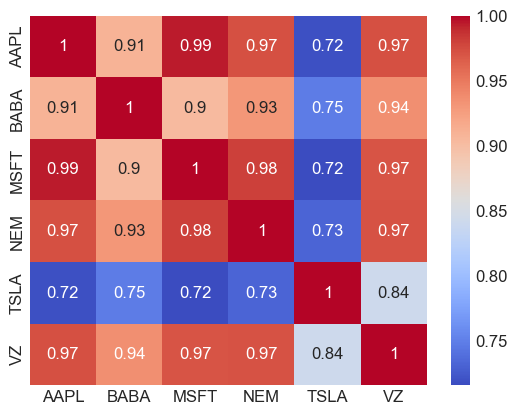

In [21]:
col_df = compare_stocks(all_stocks, days=365*1)

* Function to calculate the probalility of trend going UP or DOWN based on the previous movement over last few days.   
We can use Geometric distribution and PMF - Probability Mass Function from SciPy module to calculate the probability of the stock going up or down based on the previous movement.

In [22]:
aapl_d['UP or DOWN'].value_counts(normalize=True).loc[1] # probability of AAPL going up on any day

0.7435766547558278

In [23]:
up_chance = aapl_d['UP or DOWN'].value_counts(normalize=True).loc[1]
geom.pmf(5, up_chance)

0.0032148150490222075

In [24]:
def proba_up_down(stock_df, cont_days, period_days, direction):
    '''Calculates probability of a stock to go on specified direction for a given number of days in a row.
    '''
    if direction == 'up':
        direction_int = 1
    if direction == 'down':
        direction_int = -1
    df = stock_df.copy(deep=True)[-period_days:]
    proba = geom.pmf(cont_days, df['UP or DOWN'].value_counts(normalize=True).loc[direction_int])
    print(f'Probability of {stock_df.name} going "{direction.upper()}" for {cont_days} days in a row is {round(proba*100,3)}%. Based on {period_days} days of data.')

In [25]:
proba_up_down(aapl_d, cont_days=15, period_days=365*10, direction='down')

Probability of AAPL going "DOWN" for 15 days in a row is 0.746%. Based on 3650 days of data.


* Screen through all Nasdaq and NYSE stocks and find the top 10 trending stocks (rank based on percentage change for the day). 	Only for 1 last day.

Scraping data from NASQAD website.

In [26]:
OtherData.get_last_day_data_all_tickers(MARKETS, directory=LAST_DAY_DATA_DIR)

Downloaded nasdaq_last_day.csv
Downloaded nyse_last_day.csv


#### Top 10 trending stocks for the last day.

In [27]:
nasdaq_df = pd.read_csv(r'..\P1-Indicators-Chart-Analysis\Data\Last Day\nasdaq_last_day.csv')
nyse_df = pd.read_csv(r'..\P1-Indicators-Chart-Analysis\Data\Last Day\nyse_last_day.csv')

In [28]:
total_markets_fd = pd.concat([nasdaq_df, nyse_df], axis=0)
total_markets_fd.shape 

(7529, 11)

In [29]:
#cleaning data before sorting
print(total_markets_fd.loc[:,'% Change'].isna().sum())
total_markets_fd.loc[:,'% Change'] = total_markets_fd.loc[:,'% Change'].fillna('0.00%')
print(total_markets_fd.loc[:,'% Change'].isna().sum())
total_markets_fd.loc[:,'% Change'] = total_markets_fd.loc[:,'% Change'].apply(lambda x: float(x.strip('%')))

1
0


C:\Users\Vasyl\AppData\Local\Temp\ipykernel_11200\1650416781.py:5: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  total_markets_fd.loc[:,'% Change'] = total_markets_fd.loc[:,'% Change'].apply(lambda x: float(x.strip('%')))


In [30]:
# Top 10 stocks by any market cap
total_markets_fd.sort_values(by='% Change', ascending=False).head(10)

,Symbol,Name,Last Sale,Net Change,% Change,Market Cap,Country,IPO Year,Volume,Sector,Industry
347,BEST,BEST Inc. American Depositary Shares each repr...,$2.66,1.9398,269.342,52269000.0,Cayman Islands,NaN,106117,NaN,NaN
3665,SECO,Secoo Holding Limited ADS,$1.46,0.8500,139.344,10315274.0,China,2017.0,91173809,Miscellaneous,Diversified Commercial Services
3478,REVEW,Alpine Acquisition Corporation Warrant,$0.002,0.0011,122.222,0.0,United States,2021.0,4261,Industrials,Consumer Electronics/Appliances
3173,PEARW,Pear Therapeutics Inc. Warrant,$0.0389,0.0196,101.554,0.0,United States,2021.0,30856,Technology,Computer Software: Prepackaged Software
22,ACABW,Atlantic Coastal Acquisition Corp. II Warrant,$0.07,0.0350,100.000,0.0,United States,2022.0,33536,Industrials,Consumer Electronics/Appliances
1065,CREXW,Creative Realities Inc. Warrant,$0.0189,0.0094,98.947,0.0,United States,NaN,850,Technology,EDP Services
2069,IFRX,InflaRx N.V. Common Stock,$3.77,1.7200,83.902,168533187.0,Germany,2017.0,16050412,Health Care,Biotechnology: Pharmaceutical Preparations
818,CDLX,Cardlytics Inc. Common Stock,$6.24,2.7900,80.870,209699999.0,United States,2018.0,71292156,Consumer Discretionary,Advertising
2417,LGSTW,Semper Paratus Acquisition Corporation Warrant,$0.1037,0.0454,77.873,0.0,United States,2022.0,94000,Finance,Blank Checks
2365,LATGW,LatAmGrowth SPAC Warrants,$0.0597,0.0251,72.543,0.0,Mexico,2022.0,500,Finance,Blank Checks


In [31]:
# Top 10 stocks with larger than 5 billion market cap
total_markets_fd[total_markets_fd['Market Cap'] > 5e9].sort_values(by='% Change', ascending=False).head(10)

,Symbol,Name,Last Sale,Net Change,% Change,Market Cap,Country,IPO Year,Volume,Sector,Industry
920,EHC,Encompass Health Corporation Common Stock,$60.07,5.97,11.035,5.990626e+09,United States,NaN,2824694,Health Care,Medical Specialities
2935,WWE,World Wrestling Entertainment Inc. Class A Com...,$97.23,7.93,8.880,7.238397e+09,United States,NaN,9149463,Consumer Discretionary,Movies/Entertainment
1544,KGC,Kinross Gold Corporation Common Stock,$5.07,0.31,6.513,6.209736e+09,Canada,2001.0,24086683,NaN,NaN
53,AEM,Agnico Eagle Mines Limited Common Stock,$55.38,2.85,5.425,2.536409e+10,Canada,NaN,6260091,NaN,NaN
1548,FIVN,Five9 Inc. Common Stock,$74.10,3.26,4.602,5.272314e+09,United States,2014.0,2006333,Technology,EDP Services
1247,GOLD,Barrick Gold Corporation Common Stock (BC),$19.62,0.83,4.417,3.443996e+10,Canada,NaN,28762281,NaN,NaN
2025,ONON,On Holding AG Class A Ordinary Shares,$32.51,1.32,4.232,1.029007e+10,NaN,2021.0,8966755,Consumer Discretionary,Shoe Manufacturing
1339,HLN,Haleon plc American Depositary Shares (Each re...,$8.49,0.32,3.917,3.920077e+10,NaN,2022.0,6268004,NaN,NaN
1185,GFI,Gold Fields Limited American Depositary Shares,$13.98,0.52,3.863,1.249108e+10,South Africa,NaN,6191114,Basic Materials,Precious Metals
1861,NEM,Newmont Corporation,$51.35,1.88,3.800,4.079801e+10,United States,NaN,14703771,Basic Materials,Precious Metals


## Part 2 - Strategy 1 - Finding Most Linear Stocks over 90 days (~60 trading) and Intraday intervals.

#### 1. Find the trending stocks in all Nasdaq indices. Find best linear curve fit for the stocks over last 60 days and plot the results.  
#### 2. Find the trending stocks in all Nasdaq indices. For intraday data, find the best linear curve fit for the stocks over hours 9:30am - 16:00am and plot the results.

2.1 Downloading data for all Nasdaq stocks and saving it in a csv file. Last 100 points (days)

In [32]:
df_nasdaq_100_days = pd.read_csv(r'..\P1-Indicators-Chart-Analysis\Data\NASDAQ All Tickers.csv')
NASDAQ_TICKERS = df_nasdaq_100_days['ticker'].tolist()

In [33]:
# AV.get_daily_adjusted_data_for_list(NASDAQ_TICKERS, key=KEY, full_or_compact='compact')

2.2 Downloading data for all Nasdaq stocks and saving it in a csv files. For 5 min interval. Last 100 points.

In [34]:
AV.get_intraday_data_for_list(tickers_list=NASDAQ_TICKERS, 
                              directory=r'..\P1-Indicators-Chart-Analysis\Data\IntradayAll-NASDAQ-1day-5min', 
                              apikey=KEY, 
                              sleep_time=SLEEP_TIME, 
                              interval='5min', 
                              outputsize='compact')

2.3 Finding stocks trending upwards in the most linear way for Last 60 days for medium term investment analysis.  
* For this we will use Linear Regression from SKLearn module. We will correalte the stock price with the number of days and find the best fit line.  
* We can use the slope of the line to determine the trend. The slope will be positive if the stock is trending upwards and negative if the stock is trending downwards. 
* We will use the R2 score to determine how linear the trend is. The high the R2 score the more linear the trend is. We will use the R2 score to rank the stocks.

In [35]:
df_for_plot = AV.aggregate_close_prices(r'..\P1-Indicators-Chart-Analysis\Data\DailyAll-NASDAQ-100days')

In [36]:
linear_df = Analysis.find_best_linear_stock(df_for_plot)

Filtering the data to get the most linear and the least linear stocks.  
Plotting the results to check if the results make sense.

In [37]:
# Most linear
linear_df.sort_values(by='R2', ascending=False).head(5)

,ticker,R2,slope
832,EVLO,0.964900,-0.021705
309,BIOS,0.963682,0.002918
373,BURG,0.954654,-0.015516
1838,PDFS,0.951750,0.224972
1486,LSXMK,0.951645,-0.325637


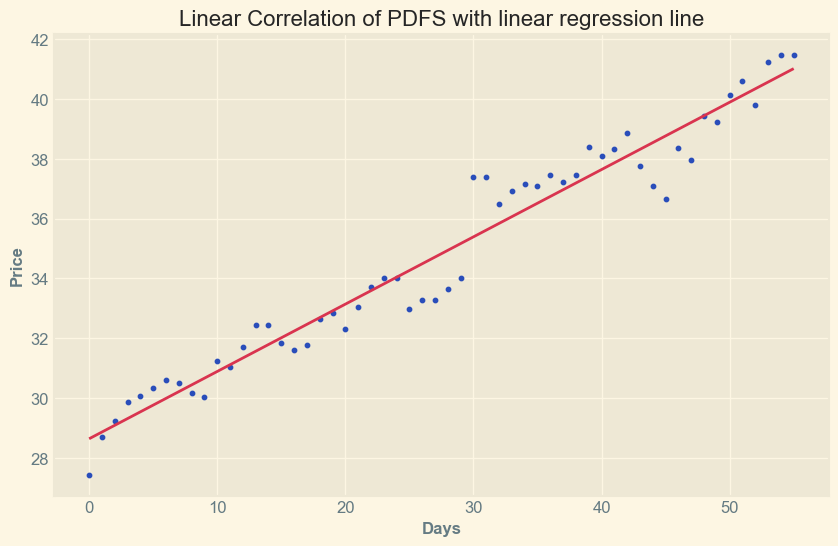

In [38]:
Analysis.plot_correlation(df_for_plot['PDFS'])

In [39]:
# Least Linear 
linear_df.sort_values(by='R2', ascending=False).tail(3)

,ticker,R2,slope
510,CLOU,0.000014,0.000174
2627,WPRT,0.000003,-0.000014
2293,STBA,0.000001,0.000162


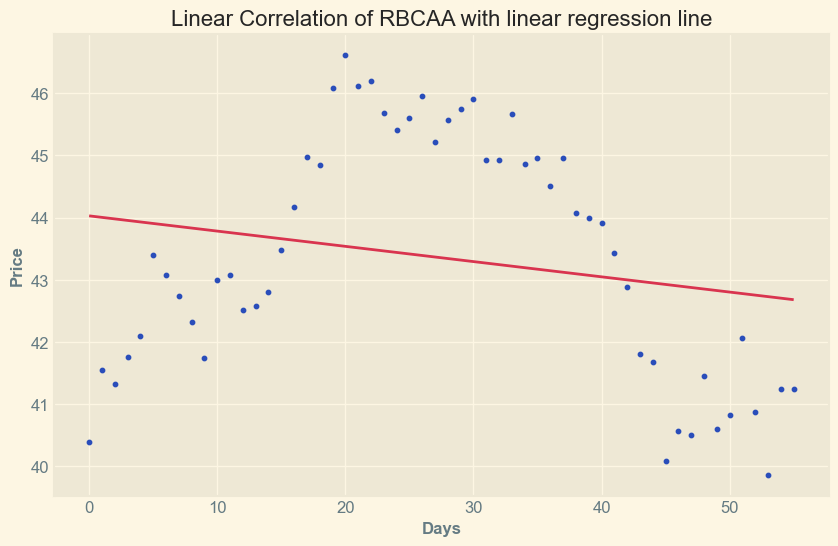

In [40]:
Analysis.plot_correlation(df_for_plot['RBCAA'])

2.4 Building aggregate dataframe of statistics for intraday 5min data

In [41]:
df_for_plot_intraday = AV.aggregate_close_prices(r'..\P1-Indicators-Chart-Analysis\Data\IntradayAll-NASDAQ-1day-5min', intraday=True)

In [42]:
df_for_plot_intraday.shape

(43, 1469)

In [43]:
linear_df_intraday = Analysis.find_best_linear_stock(df_for_plot_intraday)

In [44]:
# Most linear
linear_df_intraday.sort_values(by='R2', ascending=False).head(5)

,ticker,R2,slope
70,AMGN,0.973555,0.109739
1229,SRDX,0.968070,0.025836
1401,VRTX,0.963356,0.201603
1038,PPC,0.961045,0.018689
395,ECOR,0.960681,0.029524


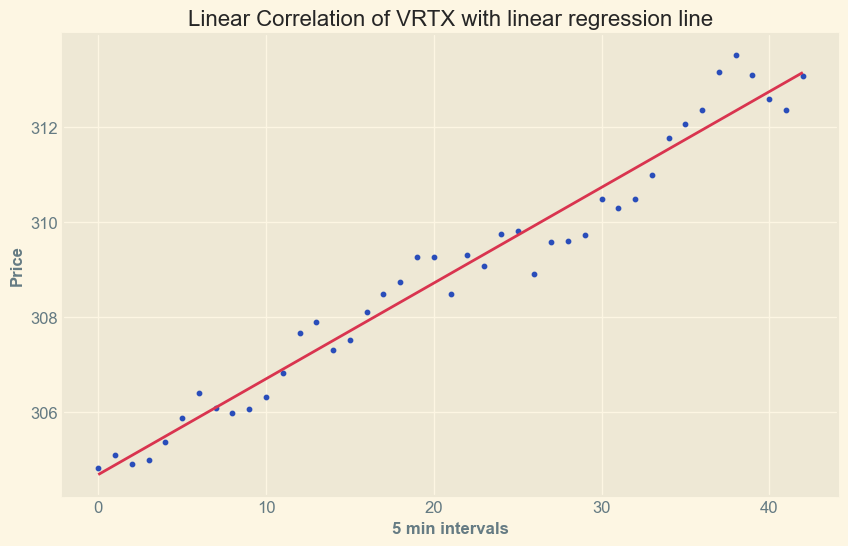

In [45]:
Analysis.plot_correlation(df_for_plot_intraday['VRTX'], intervals='5 min intervals')

In [46]:
# Least Linear
linear_df_intraday.sort_values(by='R2', ascending=False).tail(3)

,ticker,R2,slope
825,MESA,2.574091e-06,2.053760e-06
99,APTO,1.035966e-06,-9.211719e-07
918,NUVA,2.311431e-07,-5.285412e-06


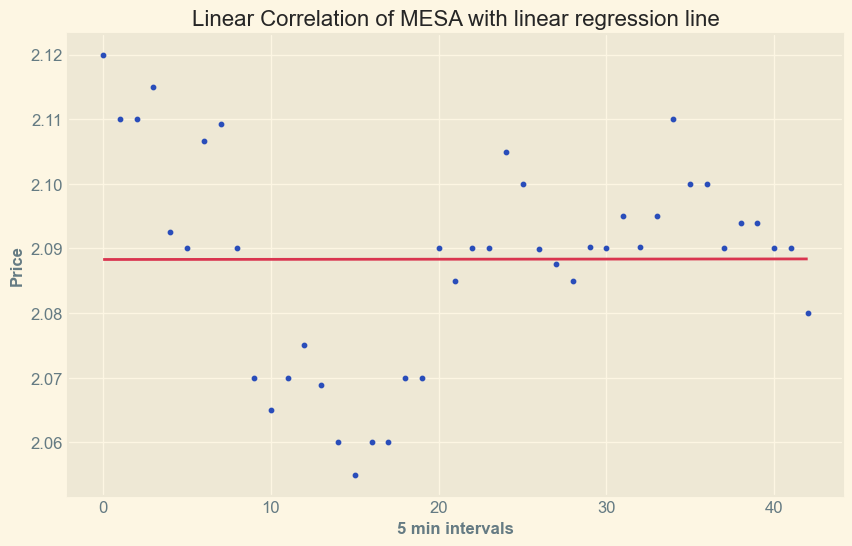

In [47]:
Analysis.plot_correlation(df_for_plot_intraday['MESA'], intervals='5 min intervals')

## Part 3 - Strategy 2 - Finding basic indicators for the stocks and plotting them.

In this section we will use the "ta" library to calculate the indicators for the stocks.
* Using Daily data collected previously we will implement next indicators: 
    * SMA - Simple Moving Average
    * EMA - Exponential Moving Average (Exponential)
    * WMA - Weighted Moving Average (Linear)
    * AMA - Adaptive Moving Average (Reacts to volatility faster than other moving averages) - Kaufman Adaptive Moving Average
    * MACD - Moving Average Convergence Divergence
    * RSI - Relative Strength Index
    * Bollinger Bands
    * OBV - On Balance Volume

In [2]:
# Load data
df = pd.read_csv(r'..\P1-Indicators-Chart-Analysis\Data\Daily\AAPL-daily.csv', index_col=0, parse_dates=True)

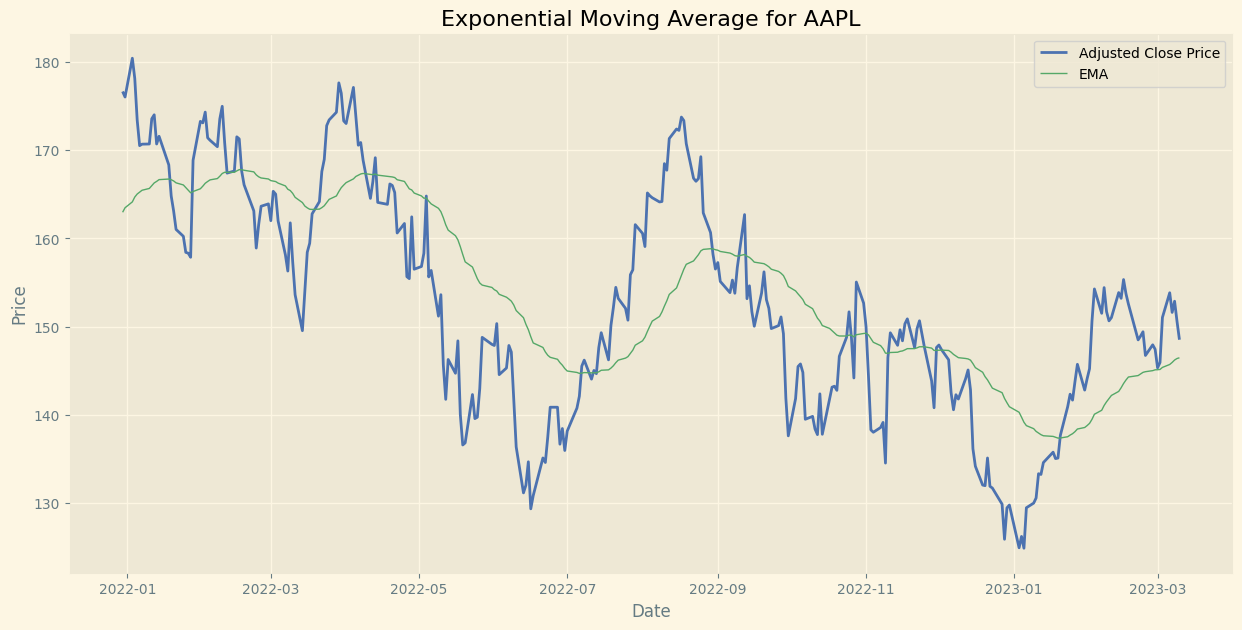

In [3]:
_ = Ind.calc_plot_EMA(df, stock_name='AAPL', window=50, plot=True, plot_days_back=300)

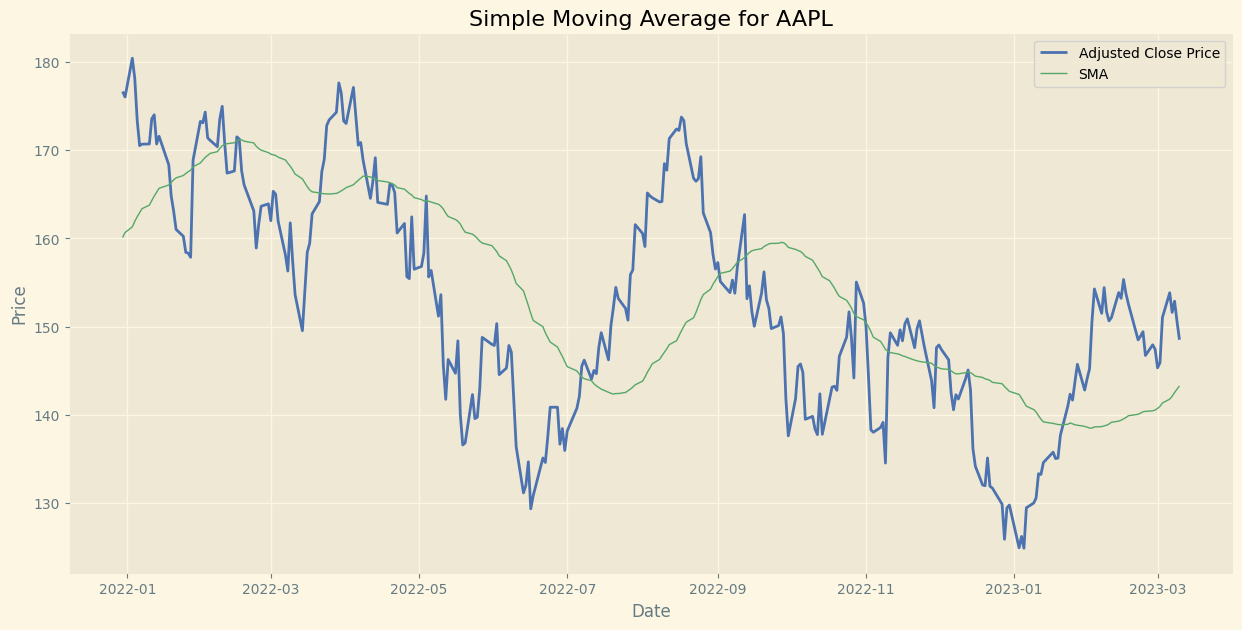

In [4]:
_ = Ind.calc_plot_SMA(df, stock_name='AAPL', window=50, plot=True, plot_days_back=300)

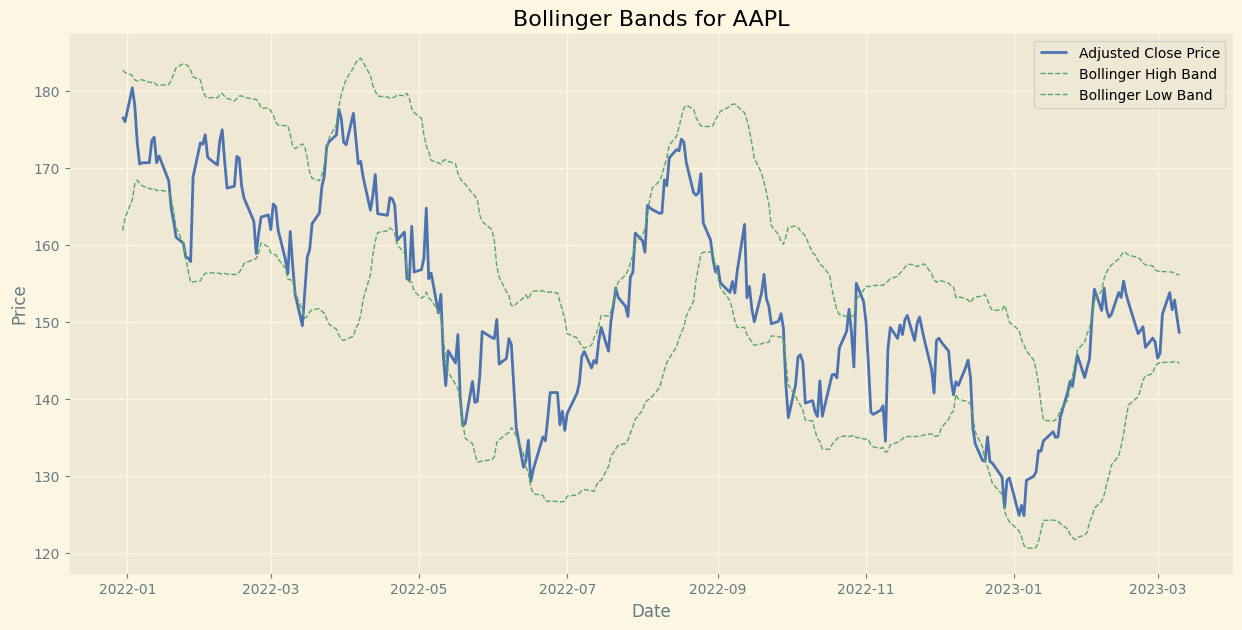

In [5]:
_= Ind.calc_plot_BollingersBands(df, stock_name='AAPL',window=20, plot=True, plot_days_back=300)

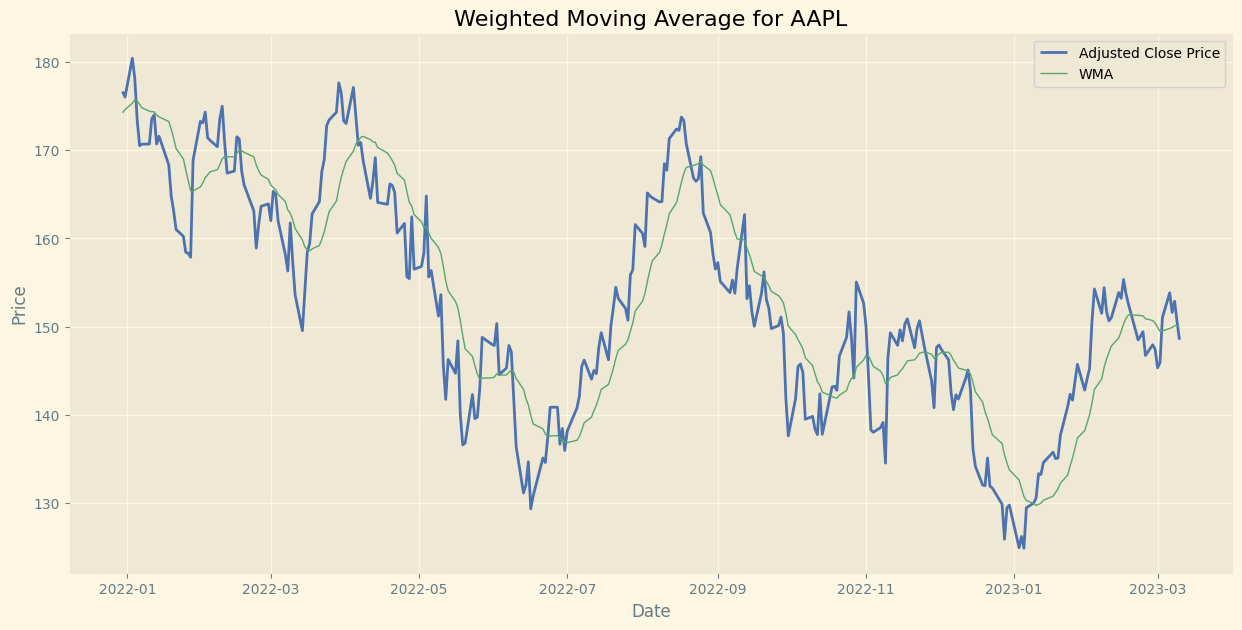

In [6]:
_= Ind.calc_plot_WMA(df, stock_name='AAPL',window=20, plot=True, plot_days_back=300)

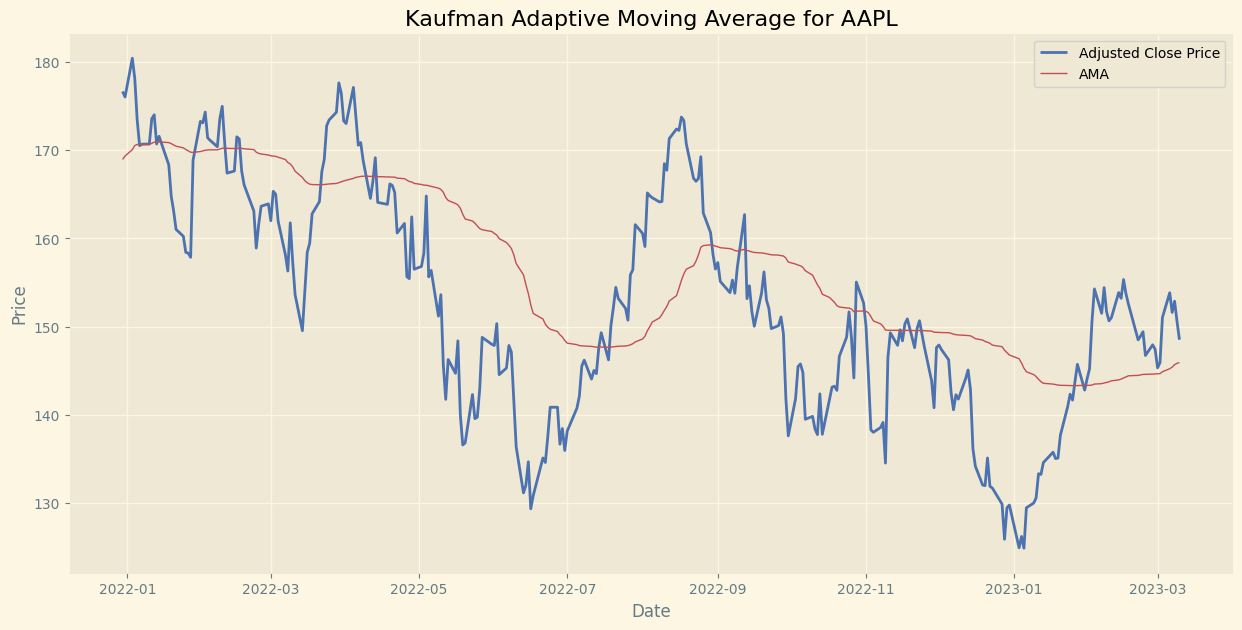

In [7]:
_= Ind.calc_plot_AMA(df, stock_name='AAPL', window=50, plot=True, plot_days_back=300)

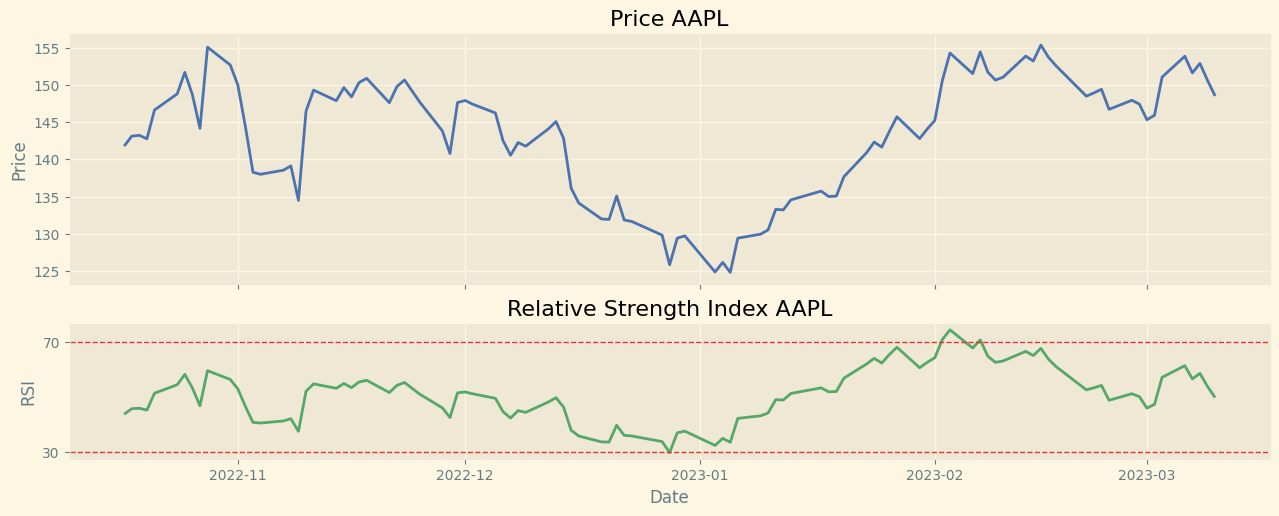

In [8]:
_= Ind.calc_plot_RSI(df, stock_name='AAPL',window=14, plot=True, plot_days_back=100)

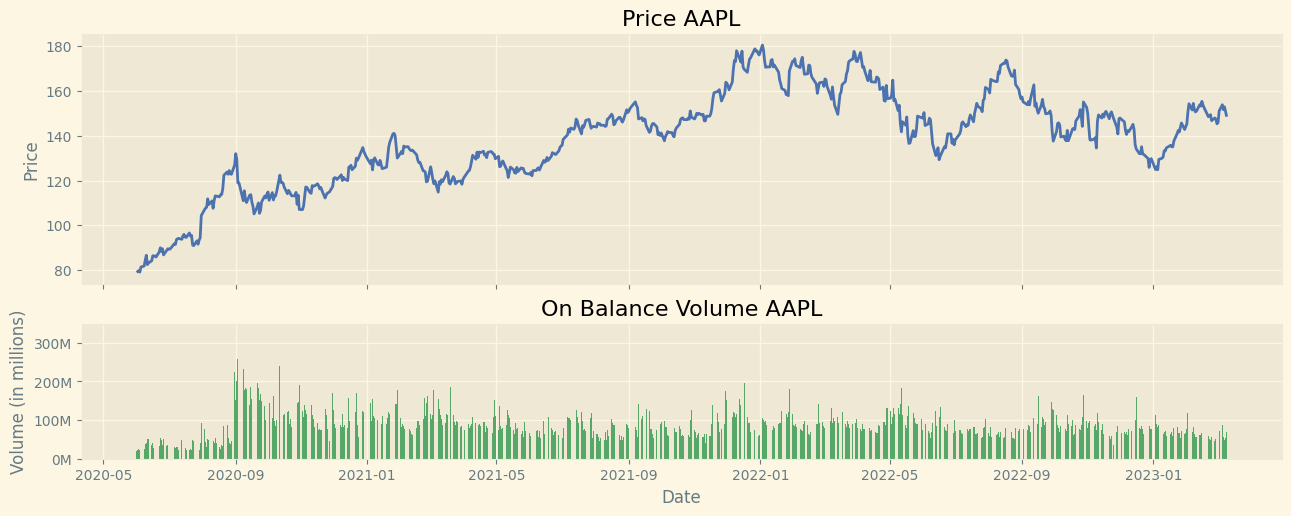

In [9]:
_= Ind.calc_plot_OBV(df, stock_name='AAPL', plot=True, plot_days_back=700)